In [2]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import math 
from typing import List, Union, Optional
from astropy.time import Time
import missingno as msno

def open_ErYb_data(data_path):
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Yb_ErYb", "fb_Al_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    data.index = range(len(data))
 
    return data[list(types.keys())]

def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data

def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=24, delimiter="\t", dtype={1: str}, engine="python")

    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t",  dtype={1: str}, engine="python")
 
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    data["shift"] = data["shift"].apply(float)
 
    return data
 
def open_maser_correction(datapath):
    data = pd.read_csv(datapath, header=1, delimiter=",", dtype={1: str}, engine="python")
 
    data.columns = ["date", "maser_offset"]
 
    data["date"] = data["date"].str.split("-").str.join("")
    data["maser_offset"] = data["maser_offset"].apply(float)
 
    return data

days = [20250116, 20250124, 20250204, 20250227, 20250304, 20250307, 20250318]
days = list(map(str, days))
day_index = 6
path = "/Users/smt3/Documents/GitHub/2025 clock comparison data/"

maser_corrections = open_maser_correction(path + "daily maser offsets.csv")
data_ErYb = open_ErYb_data(path + days[day_index] + "/" + days[day_index] + "_Deglitched_ErYb_only.dat") 
shift_data_Al = open_shiftfile_Al(path + days[day_index] + "/" + days[day_index] + "_Alp_Freq_Shifts_ErYb.dat")
shift_data_Sr = open_shiftfile_Sr(path + days[day_index] + "/" + days[day_index] + "_clock_lock0.dat")
shift_data_Yb = open_shiftfile_Yb(path + days[day_index] + "/YbI_1_rerun.txt")

In [3]:
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))

def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"] 

compute_nuAl_ErYb(data_ErYb)
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 

YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
correction_condition = days[day_index] == maser_corrections["date"]
masercorrection = maser_corrections[correction_condition]["maser_offset"].apply(Decimal)

GR_shift_Al = Decimal("-8.114e-16") 
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection

common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

# msno.matrix(pd.DataFrame({'MJD': common_mjd, 'nuAl': nuAl, 'nuSr': nuSr, 'nuYb': nuYb}))
# plt.show()

# print("Missing Al comb nu: ", nuAl.isna().sum())
# print("Missing Sr comb nu: ", nuSr.isna().sum())
# print("Missing Yb comb nu: ", nuYb.isna().sum())

In [4]:
al_cond = ~shift_data_Al['shift'].isna()
Al_non_na = shift_data_Al[al_cond]
Al = pd.Series(Al_non_na['MJD'])

sr_cond = ~shift_data_Sr['shift'].isna()
Sr_non_na = shift_data_Sr[sr_cond]
Sr = pd.Series(Sr_non_na['MJD'])

yb_cond = ~shift_data_Yb['shift'].isna()
Yb_non_na = shift_data_Yb[yb_cond]
Yb = pd.Series(Yb_non_na['MJD']) 

comb_condition = (~data_ErYb['nuAl'].isna() & ~data_ErYb['nuSr'].isna() & ~data_ErYb['nuYb'].isna())
comb_full = data_ErYb[comb_condition]

# plt.figure()
# plt.scatter(Al, pd.Series([1] * len(Al)), label = 'Al mjd', s=10)
# plt.scatter(Sr, pd.Series([1.25] * len(Sr)), label = 'Sr mjd', s=10)
# plt.scatter(Yb, pd.Series([1.5] * len(Yb)), label = 'Yb mjd', s=10)
# plt.scatter(pd.Series(comb_full['MJD']), pd.Series([0.5] * len(comb_full['MJD'])), label = 'Comb', s=10)
# plt.ylim(0,2.5)
# plt.yticks([])
# plt.title('Missing Shift and Comb Data')
# plt.xlabel("MJD Value")
# plt.legend()
# plt.tight_layout()
# plt.show()

# print("NA Al shift values: ", shift_data_Al['shift'].isna().sum())
# print("NA Sr shift values: ", shift_data_Sr['shift'].isna().sum())
# print("NA Yb shift values: ", shift_data_Yb['shift'].isna().sum())

In [5]:
good_condition_al = Al_non_na["IS_GOOD"] == 1
shift_data_Al_good = Al_non_na[good_condition_al].reset_index(drop=True, inplace = False)
Al_good = pd.Series(shift_data_Al_good['MJD'])

good_condition_sr = Sr_non_na["IS_GOOD"] == 1
shift_data_Sr_good = Sr_non_na[good_condition_sr].reset_index(drop=True, inplace = False)
Sr_good = pd.Series(shift_data_Sr_good['MJD'])

good_condition_yb = Yb_non_na["IS_GOOD"] == 1
shift_data_Yb_good = Yb_non_na[good_condition_yb].reset_index(drop=True, inplace = False)
Yb_good = pd.Series(shift_data_Yb_good['MJD']) 

# plt.figure()
# plt.scatter(Al_good, pd.Series([1] * len(Al_good)), label = 'Al', s=10)
# plt.scatter(Sr_good, pd.Series([1.25] * len(Sr_good)), label = 'Sr', s=10)
# plt.scatter(Yb_good, pd.Series([1.5] * len(Yb_good)), label = 'Yb', s=10)
# plt.scatter(pd.Series(comb_full['MJD']), pd.Series([0.5] * len(comb_full['MJD'])), label = 'Comb', s=10)
# plt.ylim(0,2.5)
# plt.yticks([])
# plt.title('Gaps in Quality Shift Data and Missing Comb Data')
# plt.xlabel("MJD Value")
# plt.legend()
# plt.tight_layout()
# plt.show()

# ## Visualize missing shift values for each clock's "good" data   
# print("NA Al shift values: ", shift_data_Al_good['shift'].isna().sum())
# print("NA Sr shift values: ", shift_data_Sr_good['shift'].isna().sum())
# print("NA Yb shift values: ", shift_data_Yb_good['shift'].isna().sum())

In [6]:
len_comb = len(comb_full['MJD']) 
len_Al = len(shift_data_Al_good['shift'])        
len_Sr = len(shift_data_Sr_good['shift'])        
len_Yb = len(shift_data_Yb_good['shift'])

# print("Comb start and end MJD: [", '{:0.11}'.format(comb_full['MJD'].iloc[0]), ', ', '{:0.11}'.format(comb_full['MJD'].iloc[len_comb-1]), ']')
# print("Al good shift start and end MJD: [", shift_data_Al_good['MJD'].iloc[0], ', ', shift_data_Al_good['MJD'].iloc[len_Al-1], ']')
# print("Sr good shift start and end MJD: [", shift_data_Sr_good['MJD'].iloc[0], ', ', shift_data_Sr_good['MJD'].iloc[len_Sr-1], ']')
# print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'].iloc[0], ', ', shift_data_Yb_good['MJD'].iloc[len_Yb-1], ']')

starts = [comb_full['MJD'].iloc[0], shift_data_Al_good['MJD'].iloc[0], shift_data_Sr_good['MJD'].iloc[0], shift_data_Yb_good['MJD'].iloc[0]] 
ends = [comb_full['MJD'].iloc[len_comb-1], shift_data_Al_good['MJD'].iloc[len_Al-1], shift_data_Sr_good['MJD'].iloc[len_Sr-1], shift_data_Yb_good['MJD'].iloc[len_Yb-1]] 

last_start_time = max(starts)
first_end_time = min(ends)

# print("Last start time: ", last_start_time)
# print("First end time: ", first_end_time)

In [7]:
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data.iloc[inx] < target:
            inx += 1
        else:
            return inx  

def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data.iloc[len(data)-inx] > target:
            inx += 1
        else:
            return len(data)-inx 
        
comb_start = ub_extract(target = last_start_time, data = comb_full['MJD'])  
comb_end = lb_extract(target = first_end_time, data = comb_full['MJD']) 

comb = pd.DataFrame()
comb["MJD"] = comb_full['MJD'].iloc[comb_start:comb_end] 
comb["nuAl"] = comb_full['nuAl'].iloc[comb_start:comb_end]
comb["nuSr"] = comb_full['nuSr'].iloc[comb_start:comb_end]
comb["nuYb"] = comb_full['nuYb'].iloc[comb_start:comb_end]
comb.reset_index(drop=True, inplace=True)

al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al = shift_data_Al_good[al_start:al_end] 
shift_data_Al.reset_index(drop=True, inplace=True)

sr_start = ub_extract(target = last_start_time, data = shift_data_Sr_good["MJD"])
sr_end = lb_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])  
shift_data_Sr = shift_data_Sr_good[sr_start:sr_end]
shift_data_Sr.reset_index(drop=True, inplace=True)

yb_start = ub_extract(target = last_start_time, data = shift_data_Yb_good["MJD"])
yb_end = lb_extract(target = first_end_time, data = shift_data_Yb_good["MJD"])  
shift_data_Yb = shift_data_Yb_good[yb_start:yb_end]
shift_data_Yb.reset_index(drop=True, inplace=True)

# print("nuAl, nuSr, and nuYb start and end MJD: [", '{:0.11}'.format(comb["MJD"].iloc[0]), ', ', '{:0.11}'.format(comb["MJD"].iloc[len(comb["MJD"])-1]), ']')
# print("Al good shift start and end MJD: [", shift_data_Al['MJD'].iloc[0], ', ', shift_data_Al['MJD'].iloc[len(shift_data_Al['MJD'])-1], ']')
# print("Sr good shift start and end MJD: [", shift_data_Sr['MJD'].iloc[0], ', ', shift_data_Sr['MJD'].iloc[len(shift_data_Sr['MJD'])-1], ']')
# print("Yb good shift start and end MJD: [", shift_data_Yb['MJD'].iloc[0], ', ', shift_data_Yb['MJD'].iloc[len(shift_data_Yb['MJD'])-1], ']')

In [8]:
comb_datetime = comb.copy()
comb_datetime['datetime'] = Time(comb_datetime['MJD'], format = 'mjd').to_datetime()
comb_datetime = comb_datetime.set_index('datetime')

shift_data_Al_datetime = shift_data_Al.copy()
shift_data_Al_datetime['datetime'] = Time(shift_data_Al_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Al_datetime = shift_data_Al_datetime.set_index('datetime')

shift_data_Sr_datetime = shift_data_Sr.copy()
shift_data_Sr_datetime['datetime'] = Time(shift_data_Sr_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Sr_datetime = shift_data_Sr_datetime.set_index('datetime')

shift_data_Yb_datetime = shift_data_Yb.copy()
shift_data_Yb_datetime['datetime'] = Time(shift_data_Yb_datetime['MJD'], format = 'mjd').to_datetime()
shift_data_Yb_datetime = shift_data_Yb_datetime.set_index('datetime')

Al_shift = shift_data_Al_datetime['shift']
Sr_shift = shift_data_Sr_datetime['shift']
Yb_shift = shift_data_Yb_datetime['shift']

interp_times_Al = comb_datetime.index.difference(Al_shift.index) 
long_Al_index = Al_shift.index.union(interp_times_Al).sort_values()
Al_shift_expanded = Al_shift.reindex(long_Al_index)

interp_times_Sr = comb_datetime.index.difference(Sr_shift.index) 
long_Sr_index = Sr_shift.index.union(interp_times_Sr).sort_values()
Sr_shift_expanded = Sr_shift.reindex(long_Sr_index)

interp_times_Yb = comb_datetime.index.difference(Yb_shift.index) 
long_Yb_index = Yb_shift.index.union(interp_times_Yb).sort_values()
Yb_shift_expanded = Yb_shift.reindex(long_Yb_index)

## Interpolation 
#### Regular Interpolation

In [9]:
# interp_method = 'cubic' 
# interp_limit = 10

# Al_shift_interpolated = Al_shift_expanded.interpolate(method=interp_method, limit=interp_limit)
# Al_shift_final = Al_shift_interpolated[comb_datetime.index]

# Sr_shift_interpolated = Sr_shift_expanded.interpolate(method=interp_method, limit=interp_limit)
# Sr_shift_final = Sr_shift_interpolated[comb_datetime.index]

# Yb_shift_interpolated = Yb_shift_expanded.interpolate(method=interp_method, limit=interp_limit)
# Yb_shift_final = Yb_shift_interpolated[comb_datetime.index]

In [10]:
# data = {
#     "comb": comb_datetime.index.diff()
# } 
# mjd_diff = pd.DataFrame(data)

# print(mjd_diff.describe())

#### Kalman Smoothing 

Kalman smoothing is another interpolation technique that works by building a structural model of the time series with missing data....  

The R package [`imputeTS`](https://cran.r-project.org/web/packages/imputeTS/vignettes/imputeTS-Time-Series-Missing-Value-Imputation-in-R.pdf) is specifically designed to handle the problem of imputation (and interpolation) for univariate time series data. This package easily enables all the same data visualization and imterpolation techniques that have been thus far presented. In addition, this package contains a function `na_kalman()` which performs interpolation by Kalman smoothing and state space models. Similar to the `limit` parameter of the Pandas function `interpolate(), `na_kalman()` also contains a parameter `maxgap` where the user can specify the maximum number of successive missing values over which to still perform interpolation. 

By default, `na_kalman()` uses a structural model fitted by maximum likelihood as the state space model, however this can instead be changed to a state space representation of an ARIMA model by changing the parameter `model`. The Kalman filter is employed in either scenario to compute the likelihood of the state space model. 

[mention something about no decimal package for R but that floats should be precise enough] 

/Users/smt3/Documents/myvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/smt3/Documents/myvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/smt3/Documents/myvenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


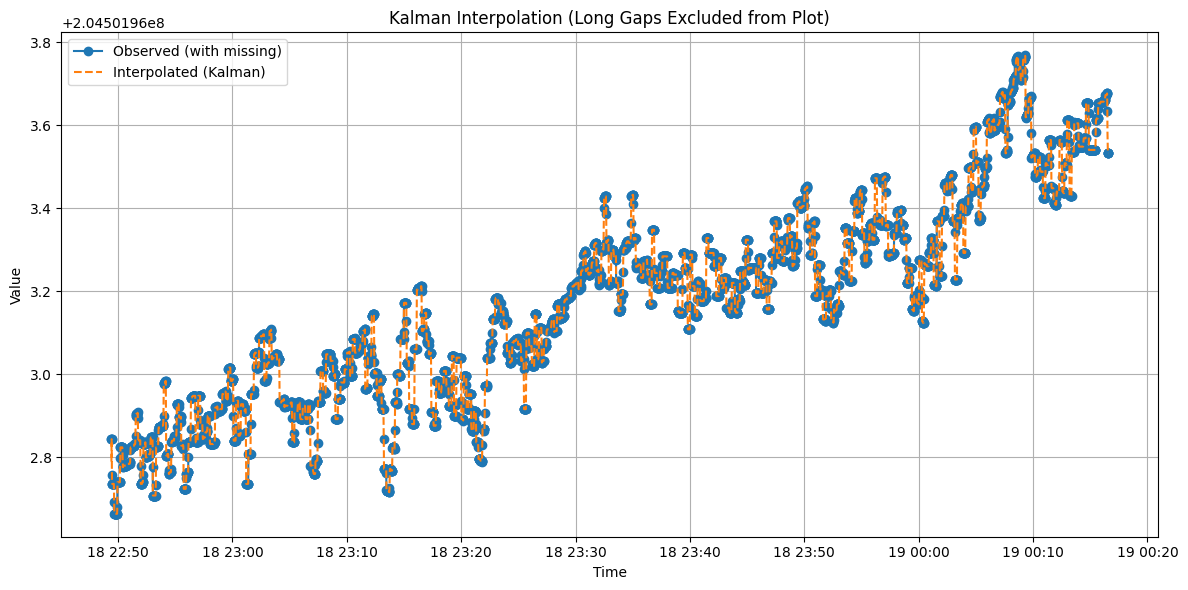

In [ ]:
import statsmodels.api as sm
# for y_series a time series with missing values... 
# Al_shift_expanded
# Sr_shift_expanded
# Yb_shift_expanded

# 2. Define a structural model (state space model) https://www.statsmodels.org/stable/statespace.html
# This defines a local level model: y_t = level_t + noise, which is appropriate for capturing gradual changes in growth rate
Al_model = sm.tsa.UnobservedComponents(Al_shift_expanded, level='local level')
Sr_model = sm.tsa.UnobservedComponents(Sr_shift_expanded, level='local level')
Yb_model = sm.tsa.UnobservedComponents(Yb_shift_expanded, level='local level')

# 3. Fit the model using Maximum Likelihood Estimation (MLE)
Al_result = Al_model.fit(method='lbfgs')  # MLE step
Sr_result = Sr_model.fit(method='lbfgs')
Yb_result = Yb_model.fit(method='lbfgs')

# 4. Use the Kalman **Smoother** to estimate the latent state
# result.smoothed_state triggers the Kalman smoothing step internally
# This returns the full smoothed path of the latent state (level_t), including where data is missing
Al_smoothed_level = Al_result.smoothed_state[0]
Sr_smoothed_level = Sr_result.smoothed_state[0]
Yb_smoothed_level = Yb_result.smoothed_state[0]  

# Create a series of interpolated (smoothed) values using the estimated latent level
Al_shift_interpolated = pd.Series(Al_smoothed_level, index=Al_shift_expanded.index)
Sr_shift_interpolated = pd.Series(Sr_smoothed_level, index=Sr_shift_expanded.index)
Yb_shift_interpolated = pd.Series(Yb_smoothed_level, index=Yb_shift_expanded.index)

# 5. Identify long missing sequences (>10) to exclude from interpolation and plotting
def detect_long_missing(data, max_len=10):
    mask = data.isna()
    long_gaps = pd.Series(False, index=data.index)

    start = None
    for i, val in enumerate(mask):
        if val and start is None:
            start = i
        elif not val and start is not None:
            if i - start > max_len:
                long_gaps[start:i] = True
            start = None
    if start is not None and len(data) - start > max_len:
        long_gaps[start:] = True

    return long_gaps

# Detect and mask out long gaps
Al_long_gap_mask = detect_long_missing(Al_shift_expanded, max_len=10)
Al_shift_interpolated[Al_long_gap_mask] = np.nan
#Al_shift_expanded[Al_long_gap_mask] = np.nan  # Mask for plotting as well
Al_shift_final = Al_shift_interpolated[comb_datetime.index]

Sr_long_gap_mask = detect_long_missing(Sr_shift_expanded, max_len=10)
Sr_shift_interpolated[Sr_long_gap_mask] = np.nan
Sr_shift_final = Sr_shift_interpolated[comb_datetime.index]

Yb_long_gap_mask = detect_long_missing(Yb_shift_expanded, max_len=10)
Yb_shift_interpolated[Yb_long_gap_mask] = np.nan
Yb_shift_final = Yb_shift_interpolated[comb_datetime.index]


# 6. Plot only observed and interpolated points outside long gaps
plt.figure(figsize=(12, 6))
plt.plot(Al_shift_expanded[4:], label='Observed (with missing)', marker='o', linestyle='-')
plt.plot(Al_shift_final[4:], label='Interpolated (Kalman)', linestyle='--')
plt.legend()
plt.title('Kalman Interpolation (Long Gaps Excluded from Plot)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


## Results

In [82]:
nuAl = [Decimal(i) for i in comb['nuAl']]
nuSr = [Decimal(i) for i in comb['nuSr']]
nuYb = [Decimal(i) for i in comb['nuYb']]

shiftAl = [Decimal(i) for i in Al_shift_final]
shiftSr = [Decimal(i) for i in Sr_shift_final]
shiftYb = [Decimal(i) for i in Yb_shift_final]

frequency_Al_ErYb = [((i + j) * total_correction_Al).iloc[0] for i, j in zip(nuAl, shiftAl)]
frequency_Sr_ErYb = [((i + j) * total_correction_Sr).iloc[0] for i, j in zip(nuSr, shiftSr)]
frequency_Yb_ErYb = [((i + j) * total_correction_Yb).iloc[0] for i, j in zip(nuYb, shiftYb)]

frequency_ratio_ErYb1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Sr_ErYb)]
frequency_ratio_ErYb2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb, frequency_Sr_ErYb)]
frequency_ratio_ErYb3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb, frequency_Yb_ErYb)]

# del frequency_ratio_ErYb1[0]
# del frequency_ratio_ErYb2[0]
# del frequency_ratio_ErYb3[0]

print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1)))
print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2)))
print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3)))

print(frequency_ratio_ErYb1[1:5])

Al+/Sr ratio offset from BACON paper -1.3849E-10
Yb/Sr ratio offset from BACON paper -1.0265E-10
Al+/Yb ratio offset from BACON paper -4.0203E-11
[Decimal('-2.174640407673797583768295958E-9'), Decimal('-1.282462251115416484907932422E-9'), Decimal('-1.119656330719208144752043511E-9'), Decimal('-9.597902340126977249272638422E-10')]


In [80]:
print("Al+/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1[-1])))
print("Yb/Sr ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2[-1])))
print("Al+/Yb ratio offset from BACON paper", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3[-1])))

# from decimal import Decimal, InvalidOperation

count = sum(1 for x in frequency_ratio_ErYb1 if not x.is_nan() and x < Decimal('-1e-7'))
print(count)

# print(frequency_ratio_ErYb1)


Al+/Sr ratio offset from BACON paper -8.6135E-17
Yb/Sr ratio offset from BACON paper -3.2994E-17
Al+/Yb ratio offset from BACON paper -5.2539E-17
1


In [72]:
def overlapping_avar_fn(y, m): 
    M = len(y)

    if M < 2 * m:
        raise ValueError(f"Length of input (M={M}) must be at least 2 * m (2 * {m} = {2 * m})")

    if any(isinstance(v, Decimal) and v.is_nan() for v in y):  
        raise ValueError("Input y contains NaN values.")
    
    if m <= 0:
        raise ValueError("m must be a positive integer")

    outer_sum = 0

    for j in range(0, M - 2 * m + 1):
        inner_sum = 0
        for i in range(j, j + m):
            inner_sum += y[i + m] - y[i]
        outer_sum += inner_sum ** 2

    result = outer_sum / (2 * m**2 * (M - 2 * m + 1))
    return result

def clean_frequency_ratio(frequency_ratio_data: List[Optional[Union[float, Decimal]]]) -> List[Union[float, Decimal]]:
    return [
        x for x in frequency_ratio_data
        if x is not None
        and not (
            (isinstance(x, float) and math.isnan(x)) or
            (isinstance(x, Decimal) and x.is_nan())
        )
    ]

clean_frequency_ratio_ErYb1 = clean_frequency_ratio(frequency_ratio_ErYb1)
clean_frequency_ratio_ErYb2 = clean_frequency_ratio(frequency_ratio_ErYb2)
clean_frequency_ratio_ErYb3 = clean_frequency_ratio(frequency_ratio_ErYb3)

print("AVAR tau=", math.floor(len(clean_frequency_ratio_ErYb1)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb1)/3))))
print("AVAR tau=", math.floor(len(clean_frequency_ratio_ErYb2)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb2)/3)))) 
print("AVAR tau=", math.floor(len(clean_frequency_ratio_ErYb3)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb3, math.floor(len(clean_frequency_ratio_ErYb1)/3))))



print("Al+/Sr ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb1)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb1)/3)).sqrt()))
print("Yb/Sr ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb2)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb1, math.floor(len(clean_frequency_ratio_ErYb2)/3)).sqrt())) 
print("Al+/Yb ADEV with tau=", math.floor(len(clean_frequency_ratio_ErYb3)/3), ": ", '{:0.5}'.format(overlapping_avar_fn(clean_frequency_ratio_ErYb3, math.floor(len(clean_frequency_ratio_ErYb1)/3)).sqrt()))

AVAR tau= 1387 :  6.2196E-23
AVAR tau= 1277 :  6.3340E-23
AVAR tau= 1518 :  4.8905E-24
Al+/Sr ADEV with tau= 1387 :  7.8864E-12
Yb/Sr ADEV with tau= 1277 :  7.9586E-12
Al+/Yb ADEV with tau= 1518 :  2.2114E-12


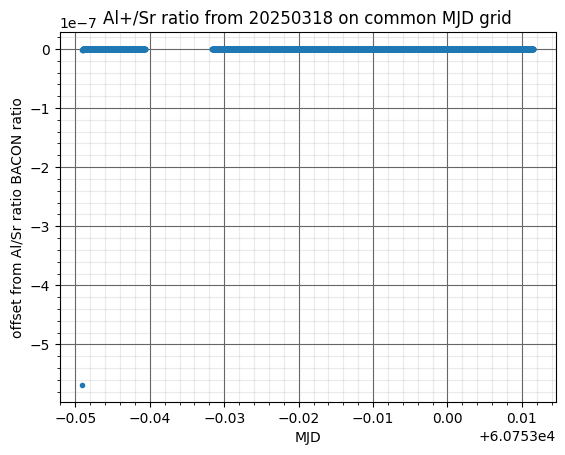

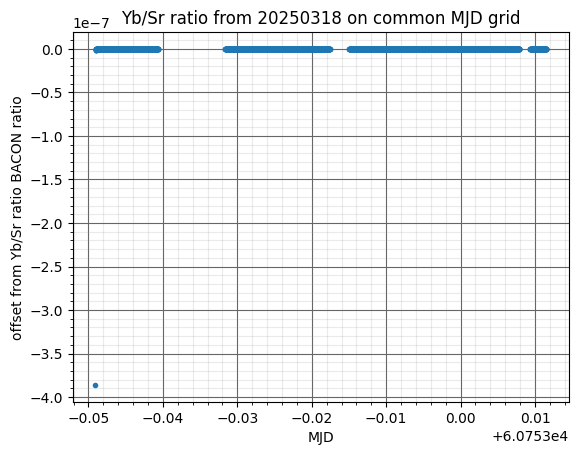

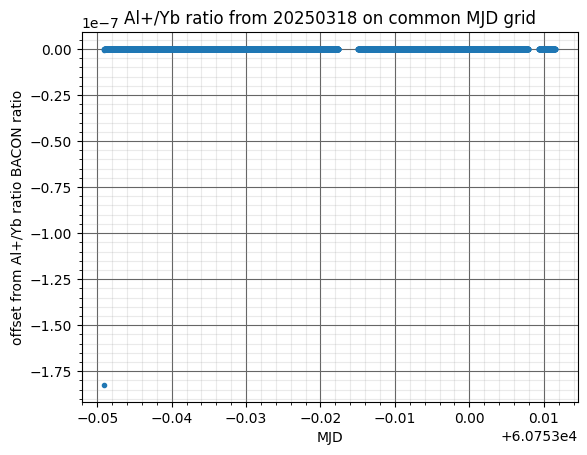

In [73]:
## Al+/Sr ratio offset  
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al+/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

## Yb/Sr ratio offset  
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from " + days[day_index] + " on common MJD grid")
plt.show()

## Al+/Yb ratio offset  
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al+/Yb ratio BACON ratio")
plt.title("Al+/Yb ratio from " + days[day_index] + " on common MJD grid")
plt.show()